In [2]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import multiprocessing

from gensim.models import Word2Vec

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
df = pd.read_csv('C:/Kaggle/simpsons_dataset.csv')
df.shape

(158314, 2)

In [3]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [4]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [5]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [6]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [7]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [8]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.77 mins


In [9]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85955, 1)

In [10]:
from gensim.models.phrases import Phrases, Phraser

In [11]:
sent = [row.split() for row in df_clean['clean']]

In [12]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 15:50:08: collecting all words and their counts
INFO - 15:50:08: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:50:08: PROGRESS: at sentence #10000, processed 63557 words and 52723 word types
INFO - 15:50:08: PROGRESS: at sentence #20000, processed 130936 words and 99612 word types
INFO - 15:50:08: PROGRESS: at sentence #30000, processed 192961 words and 138181 word types
INFO - 15:50:08: PROGRESS: at sentence #40000, processed 249832 words and 172156 word types
INFO - 15:50:08: PROGRESS: at sentence #50000, processed 311269 words and 207943 word types
INFO - 15:50:08: PROGRESS: at sentence #60000, processed 373578 words and 242950 word types
INFO - 15:50:08: PROGRESS: at sentence #70000, processed 436424 words and 277852 word types
INFO - 15:50:08: PROGRESS: at sentence #80000, processed 497887 words and 310927 word types
INFO - 15:50:08: collected 329641 token types (unigram + bigrams) from a corpus of 537095 words and 85955 sentences
INFO - 15:50:08: m

In [13]:
bigram = Phraser(phrases)

INFO - 15:50:08: exporting phrases from Phrases<329641 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 15:50:09: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<128 phrases, min_count=30, threshold=10.0> from Phrases<329641 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.62s', 'datetime': '2023-07-10T15:50:09.422776', 'gensim': '4.3.1', 'python': '3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


In [14]:
sentences = bigram[sent]

In [15]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29694

In [16]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

In [17]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [18]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 15:50:10: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2023-07-10T15:50:10.126242', 'gensim': '4.3.1', 'python': '3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


In [19]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:50:10: collecting all words and their counts
INFO - 15:50:10: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:50:10: PROGRESS: at sentence #10000, processed 61697 words, keeping 9518 word types
INFO - 15:50:10: PROGRESS: at sentence #20000, processed 127312 words, keeping 14384 word types
INFO - 15:50:10: PROGRESS: at sentence #30000, processed 187772 words, keeping 17442 word types
INFO - 15:50:10: PROGRESS: at sentence #40000, processed 243265 words, keeping 20121 word types
INFO - 15:50:10: PROGRESS: at sentence #50000, processed 303120 words, keeping 22551 word types
INFO - 15:50:10: PROGRESS: at sentence #60000, processed 363858 words, keeping 24820 word types
INFO - 15:50:10: PROGRESS: at sentence #70000, processed 425311 words, keeping 26987 word types
INFO - 15:50:10: PROGRESS: at sentence #80000, processed 485433 words, keeping 28822 word types
INFO - 15:50:10: collected 29694 word types from a corpus of 523538 raw words and 85955 sentence

Time to build vocab: 0.01 mins


In [20]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=500, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:50:11: Word2Vec lifecycle event {'msg': 'training model with 15 workers on 3325 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2023-07-10T15:50:11.057693', 'gensim': '4.3.1', 'python': '3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'train'}
INFO - 15:50:12: EPOCH 0 - PROGRESS: at 11.23% examples, 20751 words/s, in_qsize 29, out_qsize 0
INFO - 15:50:12: EPOCH 0: training on 523538 raw words (199481 effective words) took 1.5s, 130485 effective words/s
INFO - 15:50:13: EPOCH 1 - PROGRESS: at 9.45% examples, 17985 words/s, in_qsize 29, out_qsize 0
INFO - 15:50:14: EPOCH 1: training on 523538 raw words (199715 effective words) took 1.5s, 132810 effective words/s
INFO - 15:50:15: EPOCH 2 - PROGRESS: at 13.09% examples, 26045 words/s, in_qsize 29, out_qsize 7
INFO - 15:50:15: EPOCH 2: training on 523538 raw words (1994

INFO - 15:50:59: EPOCH 38 - PROGRESS: at 74.73% examples, 146072 words/s, in_qsize 14, out_qsize 1
INFO - 15:50:59: EPOCH 38: training on 523538 raw words (199745 effective words) took 1.1s, 187863 effective words/s
INFO - 15:51:00: EPOCH 39: training on 523538 raw words (199825 effective words) took 0.9s, 215621 effective words/s
INFO - 15:51:01: EPOCH 40 - PROGRESS: at 72.86% examples, 143596 words/s, in_qsize 14, out_qsize 2
INFO - 15:51:01: EPOCH 40: training on 523538 raw words (199280 effective words) took 1.1s, 189313 effective words/s
INFO - 15:51:02: EPOCH 41 - PROGRESS: at 67.19% examples, 128521 words/s, in_qsize 18, out_qsize 0
INFO - 15:51:02: EPOCH 41: training on 523538 raw words (199527 effective words) took 1.1s, 179959 effective words/s
INFO - 15:51:03: EPOCH 42: training on 523538 raw words (199402 effective words) took 1.0s, 203613 effective words/s
INFO - 15:51:04: EPOCH 43 - PROGRESS: at 67.19% examples, 132216 words/s, in_qsize 18, out_qsize 0
INFO - 15:51:04: EP

INFO - 15:51:48: EPOCH 83 - PROGRESS: at 35.35% examples, 68767 words/s, in_qsize 29, out_qsize 0
INFO - 15:51:48: EPOCH 83: training on 523538 raw words (199205 effective words) took 1.2s, 164413 effective words/s
INFO - 15:51:49: EPOCH 84: training on 523538 raw words (199246 effective words) took 1.0s, 201716 effective words/s
INFO - 15:51:50: EPOCH 85 - PROGRESS: at 45.65% examples, 90968 words/s, in_qsize 27, out_qsize 2
INFO - 15:51:50: EPOCH 85: training on 523538 raw words (199546 effective words) took 1.1s, 176574 effective words/s
INFO - 15:51:51: EPOCH 86 - PROGRESS: at 9.45% examples, 18223 words/s, in_qsize 30, out_qsize 9
INFO - 15:51:51: EPOCH 86: training on 523538 raw words (199539 effective words) took 1.3s, 154816 effective words/s
INFO - 15:51:52: EPOCH 87 - PROGRESS: at 41.37% examples, 82020 words/s, in_qsize 29, out_qsize 0
INFO - 15:51:52: EPOCH 87: training on 523538 raw words (199374 effective words) took 1.2s, 168779 effective words/s
INFO - 15:51:54: EPOCH 8

INFO - 15:52:36: EPOCH 125 - PROGRESS: at 69.06% examples, 135388 words/s, in_qsize 17, out_qsize 0
INFO - 15:52:36: EPOCH 125: training on 523538 raw words (199265 effective words) took 1.1s, 182242 effective words/s
INFO - 15:52:37: EPOCH 126: training on 523538 raw words (199564 effective words) took 0.9s, 212404 effective words/s
INFO - 15:52:38: EPOCH 127 - PROGRESS: at 67.16% examples, 132569 words/s, in_qsize 17, out_qsize 1
INFO - 15:52:38: EPOCH 127: training on 523538 raw words (199463 effective words) took 1.1s, 181046 effective words/s
INFO - 15:52:39: EPOCH 128 - PROGRESS: at 39.36% examples, 78408 words/s, in_qsize 29, out_qsize 0
INFO - 15:52:39: EPOCH 128: training on 523538 raw words (199544 effective words) took 1.2s, 169489 effective words/s
INFO - 15:52:40: EPOCH 129 - PROGRESS: at 18.35% examples, 36281 words/s, in_qsize 29, out_qsize 0
INFO - 15:52:41: EPOCH 129: training on 523538 raw words (199395 effective words) took 1.3s, 156330 effective words/s
INFO - 15:52

INFO - 15:53:24: EPOCH 168 - PROGRESS: at 96.36% examples, 189370 words/s, in_qsize 2, out_qsize 1
INFO - 15:53:24: EPOCH 168: training on 523538 raw words (199303 effective words) took 1.0s, 194862 effective words/s
INFO - 15:53:25: EPOCH 169: training on 523538 raw words (199226 effective words) took 0.9s, 215811 effective words/s
INFO - 15:53:26: EPOCH 170 - PROGRESS: at 49.86% examples, 97986 words/s, in_qsize 27, out_qsize 0
INFO - 15:53:26: EPOCH 170: training on 523538 raw words (199078 effective words) took 1.1s, 176336 effective words/s
INFO - 15:53:27: EPOCH 171 - PROGRESS: at 72.86% examples, 143744 words/s, in_qsize 15, out_qsize 0
INFO - 15:53:27: EPOCH 171: training on 523538 raw words (199879 effective words) took 1.1s, 185067 effective words/s
INFO - 15:53:28: EPOCH 172 - PROGRESS: at 37.33% examples, 74502 words/s, in_qsize 29, out_qsize 0
INFO - 15:53:28: EPOCH 172: training on 523538 raw words (199306 effective words) took 1.2s, 165500 effective words/s
INFO - 15:53:

INFO - 15:54:10: EPOCH 209 - PROGRESS: at 59.39% examples, 116198 words/s, in_qsize 21, out_qsize 1
INFO - 15:54:10: EPOCH 209: training on 523538 raw words (199444 effective words) took 1.1s, 177961 effective words/s
INFO - 15:54:11: EPOCH 210 - PROGRESS: at 39.39% examples, 76067 words/s, in_qsize 29, out_qsize 0
INFO - 15:54:11: EPOCH 210: training on 523538 raw words (199389 effective words) took 1.2s, 167554 effective words/s
INFO - 15:54:12: EPOCH 211 - PROGRESS: at 37.41% examples, 74196 words/s, in_qsize 29, out_qsize 0
INFO - 15:54:12: EPOCH 211: training on 523538 raw words (199331 effective words) took 1.2s, 169498 effective words/s
INFO - 15:54:13: EPOCH 212: training on 523538 raw words (199347 effective words) took 1.0s, 206313 effective words/s
INFO - 15:54:14: EPOCH 213 - PROGRESS: at 41.54% examples, 82316 words/s, in_qsize 29, out_qsize 0
INFO - 15:54:15: EPOCH 213: training on 523538 raw words (199730 effective words) took 1.2s, 170574 effective words/s
INFO - 15:54:

INFO - 15:54:57: EPOCH 250: training on 523538 raw words (199462 effective words) took 1.2s, 161428 effective words/s
INFO - 15:54:58: EPOCH 251: training on 523538 raw words (199291 effective words) took 0.9s, 210401 effective words/s
INFO - 15:54:59: EPOCH 252 - PROGRESS: at 45.63% examples, 90754 words/s, in_qsize 24, out_qsize 5
INFO - 15:54:59: EPOCH 252: training on 523538 raw words (199636 effective words) took 1.2s, 173351 effective words/s
INFO - 15:55:00: EPOCH 253 - PROGRESS: at 69.06% examples, 136546 words/s, in_qsize 17, out_qsize 0
INFO - 15:55:00: EPOCH 253: training on 523538 raw words (199653 effective words) took 1.1s, 181110 effective words/s
INFO - 15:55:01: EPOCH 254 - PROGRESS: at 45.83% examples, 86693 words/s, in_qsize 29, out_qsize 0
INFO - 15:55:01: EPOCH 254: training on 523538 raw words (199596 effective words) took 1.2s, 169107 effective words/s
INFO - 15:55:03: EPOCH 255 - PROGRESS: at 37.41% examples, 74221 words/s, in_qsize 29, out_qsize 0
INFO - 15:55:

INFO - 15:55:46: EPOCH 292 - PROGRESS: at 11.32% examples, 21173 words/s, in_qsize 29, out_qsize 0
INFO - 15:55:46: EPOCH 292: training on 523538 raw words (199187 effective words) took 1.4s, 146994 effective words/s
INFO - 15:55:47: EPOCH 293 - PROGRESS: at 9.35% examples, 18567 words/s, in_qsize 25, out_qsize 6
INFO - 15:55:48: EPOCH 293: training on 523538 raw words (199248 effective words) took 1.3s, 153193 effective words/s
INFO - 15:55:49: EPOCH 294 - PROGRESS: at 37.33% examples, 74916 words/s, in_qsize 29, out_qsize 0
INFO - 15:55:49: EPOCH 294: training on 523538 raw words (198923 effective words) took 1.2s, 167887 effective words/s
INFO - 15:55:50: EPOCH 295 - PROGRESS: at 14.56% examples, 26235 words/s, in_qsize 29, out_qsize 0
INFO - 15:55:50: EPOCH 295: training on 523538 raw words (199224 effective words) took 1.4s, 142495 effective words/s
INFO - 15:55:51: EPOCH 296 - PROGRESS: at 11.23% examples, 20627 words/s, in_qsize 29, out_qsize 0
INFO - 15:55:52: EPOCH 296: traini

INFO - 15:56:33: EPOCH 331: training on 523538 raw words (199597 effective words) took 1.0s, 204915 effective words/s
INFO - 15:56:34: EPOCH 332 - PROGRESS: at 74.73% examples, 148272 words/s, in_qsize 14, out_qsize 1
INFO - 15:56:34: EPOCH 332: training on 523538 raw words (199551 effective words) took 1.1s, 187864 effective words/s
INFO - 15:56:35: EPOCH 333 - PROGRESS: at 11.32% examples, 22250 words/s, in_qsize 24, out_qsize 5
INFO - 15:56:35: EPOCH 333: training on 523538 raw words (199630 effective words) took 1.3s, 157459 effective words/s
INFO - 15:56:36: EPOCH 334 - PROGRESS: at 70.97% examples, 139992 words/s, in_qsize 16, out_qsize 0
INFO - 15:56:36: EPOCH 334: training on 523538 raw words (199699 effective words) took 1.1s, 185967 effective words/s
INFO - 15:56:37: EPOCH 335 - PROGRESS: at 13.08% examples, 26208 words/s, in_qsize 30, out_qsize 3
INFO - 15:56:38: EPOCH 335: training on 523538 raw words (199505 effective words) took 1.3s, 159214 effective words/s
INFO - 15:56

INFO - 15:57:21: EPOCH 369: training on 523538 raw words (199364 effective words) took 1.3s, 154188 effective words/s
INFO - 15:57:22: EPOCH 370 - PROGRESS: at 7.41% examples, 14758 words/s, in_qsize 25, out_qsize 0
INFO - 15:57:23: EPOCH 370: training on 523538 raw words (199330 effective words) took 1.5s, 129017 effective words/s
INFO - 15:57:24: EPOCH 371 - PROGRESS: at 39.39% examples, 78939 words/s, in_qsize 29, out_qsize 0
INFO - 15:57:24: EPOCH 371: training on 523538 raw words (199463 effective words) took 1.2s, 167959 effective words/s
INFO - 15:57:25: EPOCH 372 - PROGRESS: at 13.07% examples, 26256 words/s, in_qsize 29, out_qsize 0
INFO - 15:57:25: EPOCH 372: training on 523538 raw words (199697 effective words) took 1.3s, 158139 effective words/s
INFO - 15:57:26: EPOCH 373 - PROGRESS: at 39.56% examples, 75791 words/s, in_qsize 29, out_qsize 0
INFO - 15:57:26: EPOCH 373: training on 523538 raw words (198966 effective words) took 1.2s, 165239 effective words/s
INFO - 15:57:27

INFO - 15:58:11: EPOCH 407: training on 523538 raw words (199009 effective words) took 1.3s, 149370 effective words/s
INFO - 15:58:12: EPOCH 408 - PROGRESS: at 11.05% examples, 21367 words/s, in_qsize 29, out_qsize 0
INFO - 15:58:12: EPOCH 408: training on 523538 raw words (199424 effective words) took 1.3s, 148366 effective words/s
INFO - 15:58:13: EPOCH 409 - PROGRESS: at 70.97% examples, 136137 words/s, in_qsize 16, out_qsize 0
INFO - 15:58:13: EPOCH 409: training on 523538 raw words (198747 effective words) took 1.1s, 180604 effective words/s
INFO - 15:58:14: EPOCH 410 - PROGRESS: at 11.28% examples, 22312 words/s, in_qsize 29, out_qsize 0
INFO - 15:58:15: EPOCH 410: training on 523538 raw words (199269 effective words) took 1.4s, 144897 effective words/s
INFO - 15:58:16: EPOCH 411 - PROGRESS: at 7.41% examples, 14621 words/s, in_qsize 29, out_qsize 0
INFO - 15:58:16: EPOCH 411: training on 523538 raw words (199724 effective words) took 1.4s, 144899 effective words/s
INFO - 15:58:1

INFO - 15:59:00: EPOCH 445: training on 523538 raw words (199237 effective words) took 1.3s, 158008 effective words/s
INFO - 15:59:01: EPOCH 446 - PROGRESS: at 88.14% examples, 167657 words/s, in_qsize 1, out_qsize 0
INFO - 15:59:01: EPOCH 446: training on 523538 raw words (199037 effective words) took 1.1s, 175045 effective words/s
INFO - 15:59:02: EPOCH 447 - PROGRESS: at 67.19% examples, 132802 words/s, in_qsize 0, out_qsize 1
INFO - 15:59:02: EPOCH 447: training on 523538 raw words (199134 effective words) took 1.3s, 148943 effective words/s
INFO - 15:59:03: EPOCH 448 - PROGRESS: at 67.19% examples, 131576 words/s, in_qsize 0, out_qsize 0
INFO - 15:59:04: EPOCH 448: training on 523538 raw words (199027 effective words) took 1.4s, 146035 effective words/s
INFO - 15:59:05: EPOCH 449 - PROGRESS: at 82.30% examples, 162350 words/s, in_qsize 1, out_qsize 0
INFO - 15:59:05: EPOCH 449: training on 523538 raw words (199250 effective words) took 1.2s, 171380 effective words/s
INFO - 15:59:0

INFO - 15:59:48: EPOCH 483: training on 523538 raw words (199301 effective words) took 1.3s, 159287 effective words/s
INFO - 15:59:49: EPOCH 484 - PROGRESS: at 90.04% examples, 176560 words/s, in_qsize 0, out_qsize 0
INFO - 15:59:49: EPOCH 484: training on 523538 raw words (199340 effective words) took 1.1s, 181526 effective words/s
INFO - 15:59:50: EPOCH 485 - PROGRESS: at 72.86% examples, 143474 words/s, in_qsize 1, out_qsize 0
INFO - 15:59:50: EPOCH 485: training on 523538 raw words (199540 effective words) took 1.3s, 159164 effective words/s
INFO - 15:59:51: EPOCH 486 - PROGRESS: at 69.10% examples, 136152 words/s, in_qsize 0, out_qsize 2
INFO - 15:59:52: EPOCH 486: training on 523538 raw words (199269 effective words) took 1.4s, 144486 effective words/s
INFO - 15:59:53: EPOCH 487 - PROGRESS: at 88.14% examples, 169837 words/s, in_qsize 1, out_qsize 1
INFO - 15:59:53: EPOCH 487: training on 523538 raw words (199660 effective words) took 1.1s, 175127 effective words/s
INFO - 15:59:5

Time to train the model: 9.95 mins


In [21]:
w2v_model.init_sims(replace=True)

C:\Users\SWANNT\AppData\Local\Temp\ipykernel_23308\514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
WARNING - 16:00:08: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


In [22]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.3970673382282257),
 ('dad', 0.2548356056213379),
 ('thing', 0.23930324614048004),
 ('simpson', 0.23853224515914917),
 ('want', 0.23427224159240723),
 ('know', 0.23076802492141724),
 ('homie', 0.22180622816085815),
 ('people', 0.2201680988073349),
 ('hey', 0.21936239302158356),
 ('uh', 0.21319378912448883)]

In [23]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('simpson', 0.2060728669166565),
 ('sir', 0.20509707927703857),
 ('man', 0.19420315325260162),
 ('available', 0.1891089826822281),
 ('concern', 0.1800335794687271),
 ('american', 0.17905649542808533),
 ('scale', 0.17529737949371338),
 ('mr_simpson', 0.1743680238723755),
 ('yes', 0.17337295413017273),
 ('welcome', 0.17033115029335022)]

In [24]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.3970673382282257),
 ('thing', 0.2629895806312561),
 ('homie', 0.2560619115829468),
 ('know', 0.2463352084159851),
 ('want', 0.24322925508022308),
 ('way', 0.2363802194595337),
 ('son', 0.23032251000404358),
 ('time', 0.2233850359916687),
 ('family', 0.22020526230335236),
 ('think', 0.2166031450033188)]

In [25]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.5041964650154114),
 ('dad', 0.37489941716194153),
 ('child', 0.35102173686027527),
 ('kid', 0.33330684900283813),
 ('son', 0.3063059151172638),
 ('school', 0.3024362623691559),
 ('boy', 0.2835147976875305),
 ('think', 0.28110381960868835),
 ('student', 0.26800718903541565),
 ('mom', 0.2560880184173584)]

In [26]:
w2v_model.wv.similarity('homer', 'tavern')

0.06823659

In [27]:
w2v_model.wv.similarity('maggie', 'baby')

0.26575837

In [28]:
w2v_model.wv.similarity('bart', 'nelson')

0.1381157

In [29]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 16:00:08: vectors for words {'kearney'} are not present in the model, ignoring these words


'jimbo'

In [30]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [31]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

In [32]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('wonder', 0.227152019739151),
 ('man', 0.2080572545528412),
 ('people', 0.1893930286169052)]

In [33]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.3352735936641693),
 ('student', 0.23793968558311462),
 ('dad', 0.23723973333835602)]

In [48]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))


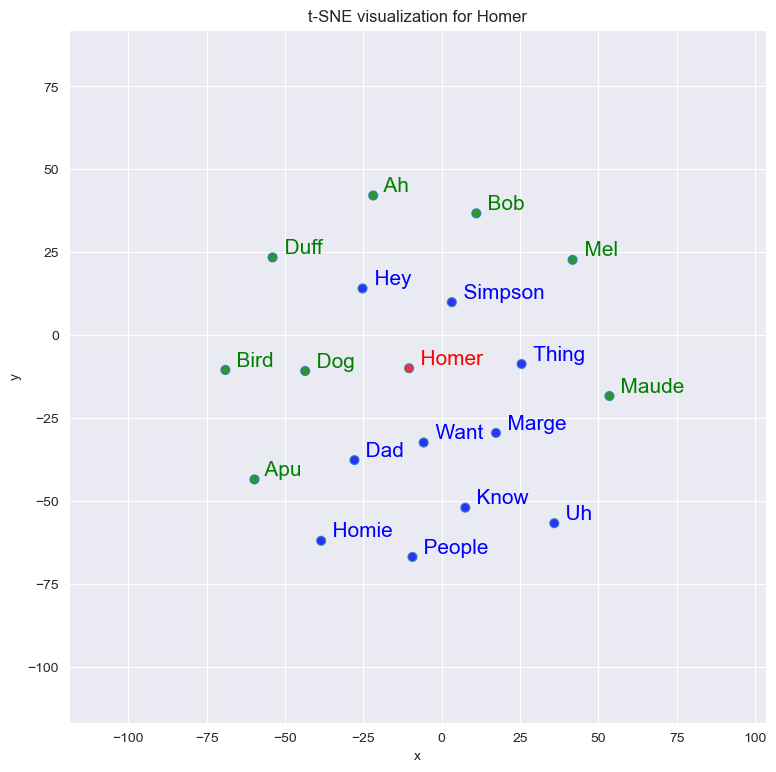

In [49]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

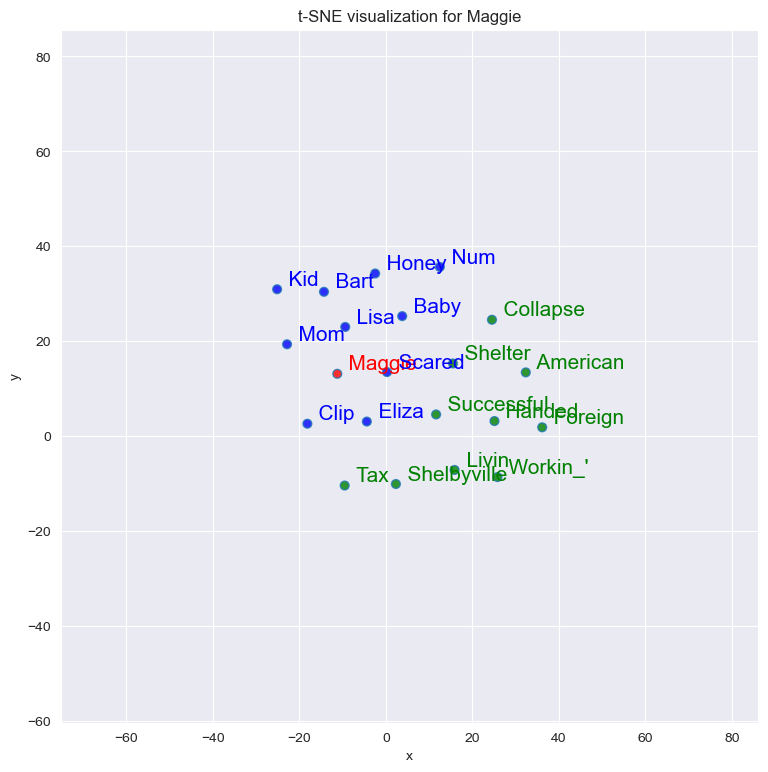

In [50]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

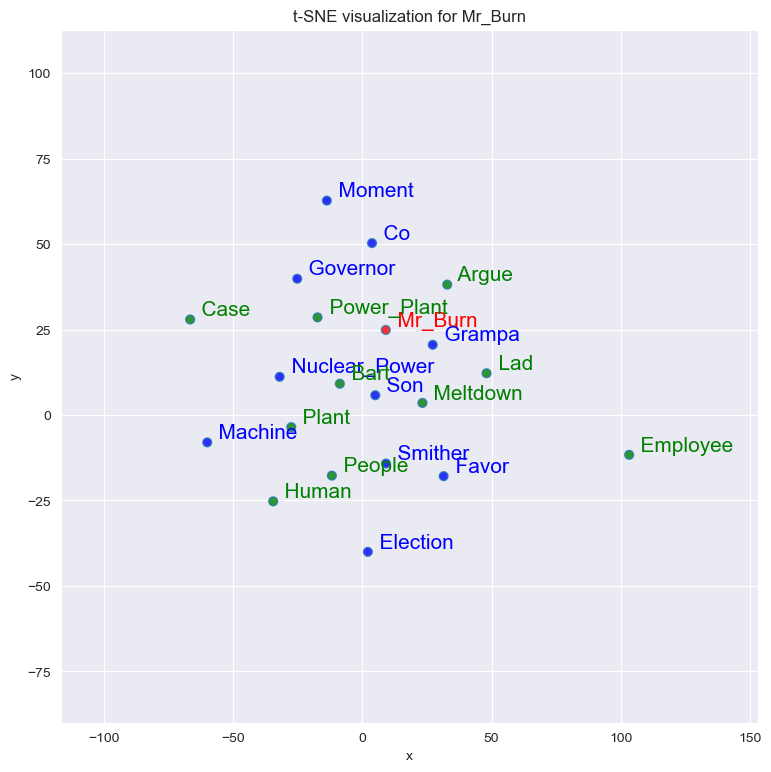

In [51]:
tsnescatterplot(w2v_model, "mr_burn", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])